In [1]:
from scipy.sparse import load_npz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.linear_model            import LogisticRegression
from tqdm                            import tqdm
from sklearn.model_selection         import train_test_split
from sklearn.model_selection         import StratifiedKFold
from sklearn                         import metrics
from wordcloud import WordCloud, STOPWORDS 
import warnings
import math as m
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
train = load_npz('task2_train.npz').tocsr()
test = load_npz('task2_test.npz').tocsr()

In [3]:
x_train= train[:,:17]
x_test= test[:,:17]

In [4]:
y_train = train.getcol(17)
y_test = test.getcol(17)

In [5]:
def GridsearchCV(x_train,y_train,classifier,folds):
    train_auc_scores = []
    cv_auc_scores    = []
    params = [0.0001,0.001,0.01,0.1,1,10,100,1000]
    for param in tqdm(params):

    # defining temperory varaibles for storing auc_score of training and cros_validation data for each fold
        train_auc_score_for_avg     = []
        cv_auc_score_for_avg        = []


    #  creating indices for each fold and iteration over each fold
        folds_indices    = StratifiedKFold(n_splits=folds,shuffle=True)
        for train_ind, cv_ind in folds_indices.split(x_train, y_train):
            train_x      = x_train[train_ind]
            train_y      = y_train[train_ind]
            cv_x         = x_train[cv_ind]
            cv_y         = y_train[cv_ind]


    # Assigning hyper-arameter to model or classifier and fitting it on training data
            classifier.C = param
            classifier.fit(train_x,train_y)

    # Predicting log_probanilities for training and cv data and calulating roc_auc_score and storing it in temperory variables
            predictions   = classifier.predict_proba(train_x)[:,1]
    #                 pdb.set_trace()
            fpr, tpr, thresholds = metrics.roc_curve(train_y,predictions, pos_label=1)  
    #                 pdb.set_trace()
    #                 print(sum(fpr),sum(tpr))
            train_auc_score_for_avg.append(metrics.auc(fpr, tpr) )                  

            predictions   = classifier.predict_proba(cv_x)[:,1]            
    #                 pdb.set_trace()
            fpr, tpr, thresholds = metrics.roc_curve(cv_y,predictions, pos_label=1)
    #                 pdb.set_trace()

            cv_auc_score_for_avg.append( metrics.auc(fpr, tpr)) 


    # Averaging the roc_auc_score values of all folds and storing it it final variable 
        train_auc_scores.append(np.mean(train_auc_score_for_avg))
        cv_auc_scores.append(np.mean(cv_auc_score_for_avg)) 
        
    return train_auc_scores,cv_auc_scores

In [6]:
def Curve_plot(train,cv,param):
    plt.grid()
    plt.plot( param,train, label='Train AUC')
    plt.plot(param, cv, label='CV AUC')
    plt.scatter( param,train,label='Train AUC points')
    plt.scatter(param, cv, label='CV AUC points')
    plt.xscale('log')
    plt.xlabel("Hyperparameters")
    plt.ylabel("AUC_Score")
    plt.legend()
    plt.title("AUC_Score VS Hypermeter")
    plt.show()

In [7]:
tr_score,te_score = GridsearchCV(x_train.toarray(),y_train.toarray(),LogisticRegression(),3)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.05s/it]


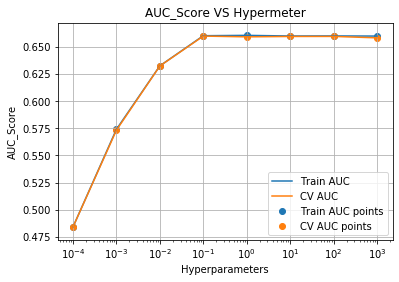

In [8]:
Curve_plot(tr_score,te_score,[0.0001,0.001,0.01,0.1,1,10,100,1000])

> Best hyper-parameter : 1

In [17]:
classifier = LogisticRegression(C=1).fit(x_train,y_train.toarray())

In [24]:
# predicting probabilities for calss label 1
prediction_train = classifier.predict_proba(x_train)[:,1]
prediction_test = classifier.predict_proba(x_test)[:,1]

In [25]:
# calculating fpr and tpr values for train and test both
train_fpr, train_tpr, train_thresholds = metrics.roc_curve(y_train.toarray(),prediction_train)  
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test.toarray(),prediction_test)  

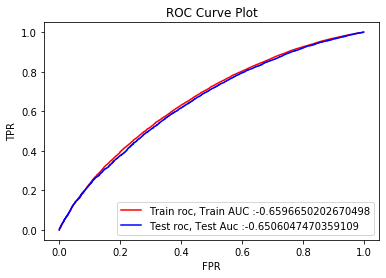

In [26]:
plt.plot(train_fpr,train_tpr,color='r',label='Train roc, Train AUC :-'+str(np.trapz(train_tpr,train_fpr)))
plt.plot(test_fpr,test_tpr,color='b',label='Test roc, Test Auc :-'+str(np.trapz(test_tpr,test_fpr)))
plt.title('ROC Curve Plot')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [27]:
thresold=train_thresholds[list(train_tpr-train_fpr).index(max(train_tpr-train_fpr))]

In [29]:
# converting prediction probability into class by taking threshold as 0.5
pred_class_train = [ 0 if prediction_train[i] < thresold else 1 for i in range(len(prediction_train))]
pred_class_test  = [ 0 if prediction_test[i] < thresold else 1 for i in range(len(prediction_test))]

In [30]:
# calculating values for confusion matrix
tn_1,fp_1,fn_1,tp_1=metrics.confusion_matrix (y_test.toarray(),pred_class_test).ravel()
# Printing Confusion Matrix 
print(f'''Confusion Matrix
     
               Predicted
             
         ___|__0___|__1____|
   A        |      |       |
   c     0  | {tn_1}   |  {fp_1} |
   t     ___|______|_______|
   u        |      |       |
   a     1  | {fn_1}   |  {tp_1}|
   l     ___|______|_______|''',)

Confusion Matrix
     
               Predicted
             
         ___|__0___|__1____|
   A        |      |       |
   c     0  | 3222   |  2237 |
   t     ___|______|_______|
   u        |      |       |
   a     1  | 11406   |  19186|
   l     ___|______|_______|


In [31]:
with open('test_datapoint_indes','rb') as f:
    ind_ser = pickle.load(f)

In [32]:
data = pd.read_csv('donor_choose.csv')

In [33]:
fp_index = []
for i in range(len(y_test.toarray())):
    if y_test.toarray()[i]==0 and pred_class_test[i]==1:
        fp_index.append(ind_ser[i])

In [34]:
# Preparing essay_text by merginng eassay column of test data for fp points
essay_txt = ''
for i in fp_index:
    essay_txt += data.iloc[i]['essay'].lower()

In [35]:
# from link provided in ref notebook
# preparing wordcloud for essay test
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(essay_txt) 

In [36]:
#  Preparing fp_price data from  price column of test data for fp points
fp_price = data.iloc[fp_index]['price']

In [37]:
#  Preparing fp_tppp data from  teacher_number_of_previously_posted_projects column of test data for fp points
fp_tppp = data.iloc[fp_index]['teacher_number_of_previously_posted_projects']

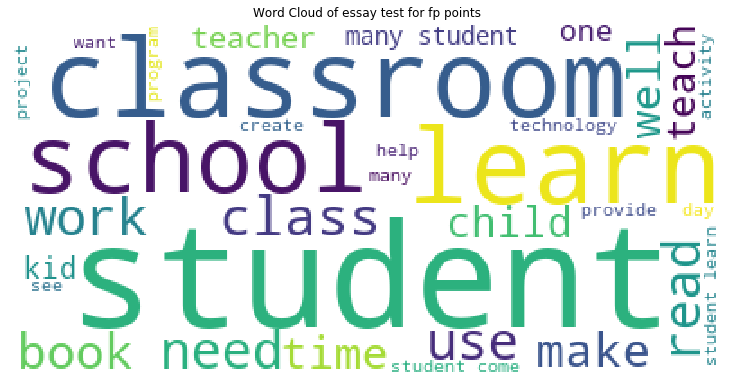

In [38]:
# plot the WordCloud image                        
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud of essay test for fp points') 
plt.show() 

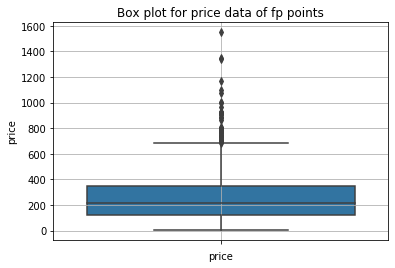

In [39]:
sns.boxplot(y=fp_price)
plt.grid()
plt.title('Box plot for price data of fp points')
plt.xlabel('price')
plt.show()

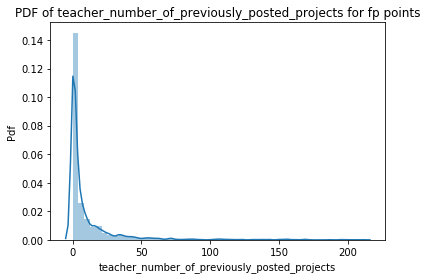

In [40]:
sns.distplot(fp_tppp)
plt.title('PDF of teacher_number_of_previously_posted_projects for fp points')
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.ylabel('Pdf')
plt.show()